https://qard.is.tohoku.ac.jp/T-Wave/?p=1136

In [1]:
# for SageMaker environment
!conda install -y attrdict

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [2]:
from collections import defaultdict
import time

import numpy as np
import matplotlib.pyplot as plt
import pickle

import pyqubo

In [3]:
# utils

def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)


def imshow(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

In [4]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

In [5]:
def build_model(data, c=10):
    x = pyqubo.Array.create('x', shape=(data.size, data.rows, data.cols), vartype='BINARY')

    costs = []
    sim_max = {'x': 0, 'y': 0}
    for a in range(data.size):
        for b in range(data.size):
            if a == b:
                continue
            sim = {
                'x': sim_x(data.images[a], data.images[b]),
                'y': sim_y(data.images[a], data.images[b])
            }
            sim_max['x'] = max(sim_max['x'], sim['x'])
            sim_max['y'] = max(sim_max['y'], sim['y'])
            for row in range(data.rows):
                for col in range(data.cols):
                    if col < data.cols - 1:
                        costs.append(-sim['x']*x[a, row, col]*x[b, row, col + 1])
                    if row < data.rows - 1:
                        costs.append(-sim['y']*x[a, row, col]*x[b, row + 1, col])


    coeff = c*(sim_max['x'] + sim_max['y'])
    for a in range(data.size):
        costs.append(coeff*pyqubo.Constraint((np.sum(x[a]) - 1)**2, f'img_{a}'))
    for row in range(data.rows):
        for col in range(data.cols):
            costs.append(coeff*pyqubo.Constraint((np.sum(x[:, row, col]) - 1)**2, f'pos_{row}_{col}'))

    return sum(costs).compile(), x

## 問題例

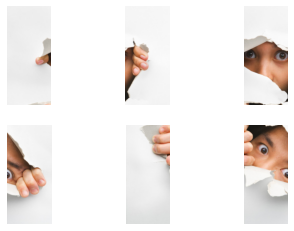

In [6]:
DATA_PATHS = [
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_3.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_50.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_50.pkl',
]

data = load_data(DATA_PATHS[0])
imshow(data.images, data.rows, data.cols)

In [7]:
def is_feasible(sample):
    return all(v[0] for v in sample.constraints().values())

def show_solution(sample, data, x):
    values = np.vectorize(lambda x: sample[x.label])(x)
    pos = np.array(np.where(values == 1)).T
    images = [
        data.images[p[0]]
        for p in sorted(pos, key=lambda x: [x[1], x[2]])
    ]
    imshow(images[:data.size], data.rows, data.cols)

In [8]:
import boto3
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite

aws_account_id = boto3.client('sts').get_caller_identity()['Account']
bucket = 'amazon-braket-ohtaman'
prefix = 'd-wave/output'
s3_location = (bucket, prefix)

# device = AwsDevice('arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
device = AwsDevice('arn:aws:braket:::device/qpu/d-wave/Advantage_system1')

sampler = BraketDWaveSampler(s3_location, device.arn)
sampler = EmbeddingComposite(sampler)

--- data: rows=2, cols=3 ---
	elapsed_time(s)=10.64633846282959
	energy=34156.0
	is_feasible=False


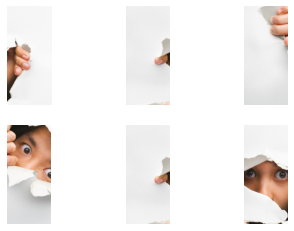

--- data: rows=2, cols=5 ---
	elapsed_time(s)=144.84308528900146
	energy=61046.0
	is_feasible=False


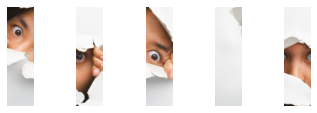

ValueError: no embedding found

In [9]:
for data_path in DATA_PATHS:
    data = load_data(data_path)
    model, x = build_model(data)
    bqm = model.to_bqm()
    start = time.time()
    samples = sampler.sample(bqm, num_reads=1000, auto_scale=True)
    elapsed_time = time.time() - start
    decoded_samples = model.decode_sampleset(samples)
    best = min(decoded_samples, key=lambda x: x.energy)

    print(f'--- data: rows={data.rows}, cols={data.cols} ---')
    print(f'\telapsed_time(s)={elapsed_time}')
    print(f'\tenergy={best.energy}')
    print(f'\tis_feasible={is_feasible(best)}')

    show_solution(best.sample, data, x)
    plt.show()

    if elapsed_time > 30*60:
        break